# FullClass-TrainCNN(InceptionV3)_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [2]:
#train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
train_dataset_path='D:/DatasetMedicalWasteCroppedBalancedOversamplingCopying/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=299
img_width=299
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15342 files belonging to 41 classes.
Using 12274 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15342 files belonging to 41 classes.
Using 3068 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


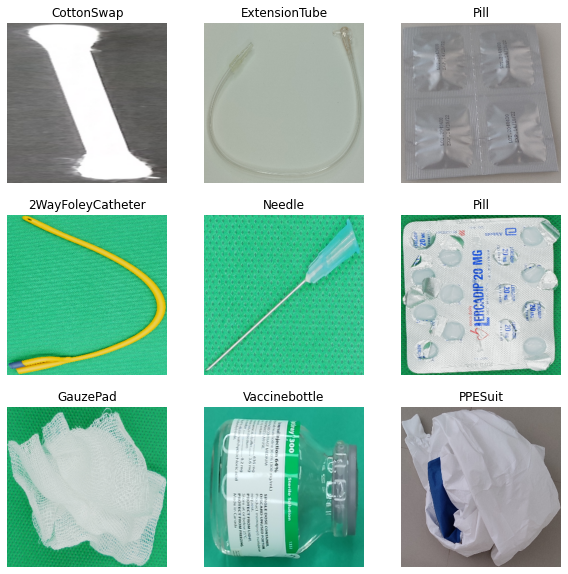

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

inceptionv3_model_nooutput = inceptionv3_model.layers[-2].output
custom_inceptionv3_model = Model(inputs = inceptionv3_model.input, outputs = inceptionv3_model_nooutput)


## Freez Extractor+

In [18]:
custom_inceptionv3_model.trainable = False
for layer in custom_inceptionv3_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_inceptionv3_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_inceptionv3_model)
# Classifier
#DeepDense
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 41)                2665      
Total params: 22,075,977
Trainable params: 273,193
Non-trainable params: 21,802,784
_________________________________________________________________


# Fitting

In [2]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-DeepDense-Oversampling-NoAug-NormalLR/'

In [22]:
EPOCHS = 200
save_model_interval = 4
checkpoint_filepath = path_to_model+'OurOutputLayer-DeepDense-Oversampling-NoAug-epoch{epoch:04d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback])

Epoch 1/200
192/192 [==============================] - 152s 305ms/step - loss: 1.2300 - accuracy: 0.6766 - val_loss: 0.1786 - val_accuracy: 0.9671
Epoch 2/200
192/192 [==============================] - 35s 183ms/step - loss: 0.2225 - accuracy: 0.9420 - val_loss: 0.0686 - val_accuracy: 0.9850
Epoch 3/200
192/192 [==============================] - 35s 184ms/step - loss: 0.1020 - accuracy: 0.9742 - val_loss: 0.0361 - val_accuracy: 0.9925
Epoch 4/200
192/192 [==============================] - 35s 184ms/step - loss: 0.0690 - accuracy: 0.9825 - val_loss: 0.0236 - val_accuracy: 0.9945
INFO:tensorflow:Assets written to: D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-DeepDense-Oversampling-NoAug-NormalLR\OurOutputLayer-DeepDense-Oversampling-NoAug-epoch0004-val_acc0.99.pb\assets
Epoch 5/200
192/192 [==============================] - 35s 184ms/step - loss: 0.0414 - accuracy: 0.9914 - val_loss: 0.0229 - val_accuracy: 0.9954
Epoch 6/200
192/192 [==============================]

Text(0.5, 1.0, 'Training and Validation Accuracy')

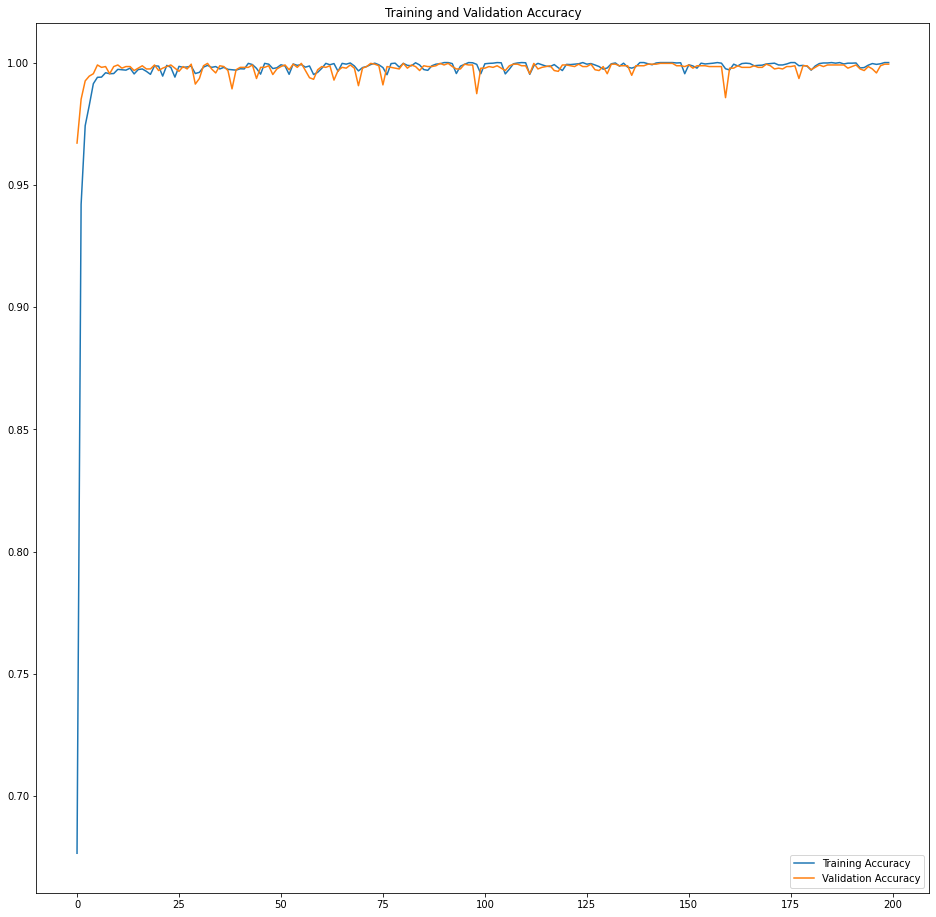

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


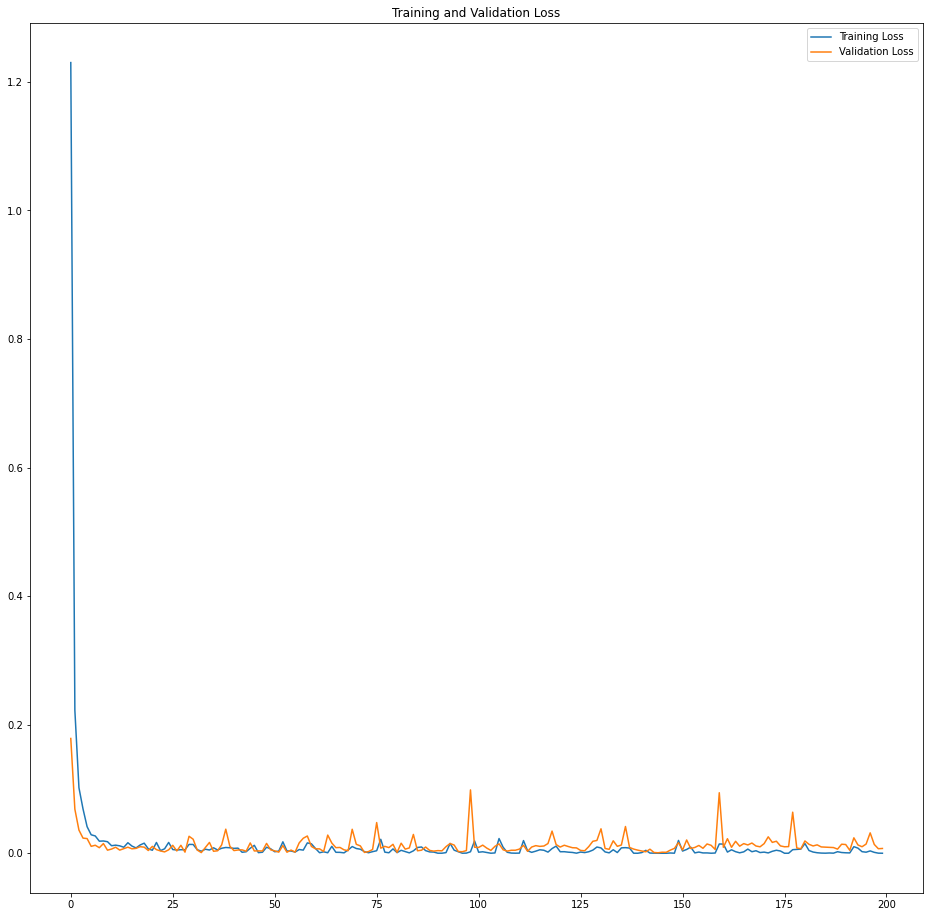

In [24]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 14s 350ms/step - loss: 2.1494 - accuracy: 0.8445
test_indoor_ds_results:test loss, test acc: [2.149392604827881, 0.8444815874099731]


In [26]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 26s 432ms/step - loss: 5.5621 - accuracy: 0.7172
test_outdoor_ds_results:test loss, test acc: [5.562050819396973, 0.7171974778175354]


In [27]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 8s 201ms/step - loss: 6.6815 - accuracy: 0.6736
test_belt_ds_results:test loss, test acc: [6.681457996368408, 0.673617422580719]


In [28]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-DeepDense-Oversampling-NoAug-NormalLR/OurOutputLayer-DeepDense-Oversampling-NoAug-epoch0004-val_acc0.99.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-DeepDense-Oversampling-NoAug-NormalLR/OurOutputLayer-DeepDense-Oversampling-NoAug-epoch0008-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-DeepDense-Oversampling-NoAug-NormalLR/OurOutputLayer-DeepDense-Oversampling-NoAug-epoch0012-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-DeepDense-Oversampling-NoAug-NormalLR/OurOutputLayer-DeepDense-Oversampling-NoAug-epoch0016-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-DeepDense-Oversampling-NoAug-NormalLR/OurOutputLayer-DeepDense-Oversampling-NoAug-epoch0020-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-DeepDense-Oversampling-NoAug-Normal

# Testing in testset

In [29]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 5s 135ms/step - loss: 1.3536 - accuracy: 0.6936
Epoch004 
 test_indoor_acc=0.8311036825180054 
 test_outdoor_acc=0.7060509324073792 
 test_belt_acc=0.6935629844665527
35/35 [==============================] - 5s 133ms/step - loss: 1.8552 - accuracy: 0.6546
Epoch008 
 test_indoor_acc=0.8138238787651062 
 test_outdoor_acc=0.7140127420425415 
 test_belt_acc=0.654578447341919
35/35 [==============================] - 5s 132ms/step - loss: 2.0982 - accuracy: 0.6537
Epoch012 
 test_indoor_acc=0.8037903904914856 
 test_outdoor_acc=0.6748407483100891 
 test_belt_acc=0.6536718010902405
35/35 [==============================] - 5s 133ms/step - loss: 2.0736 - accuracy: 0.6908
Epoch016 
 test_indoor_acc=0.8221850395202637 
 test_outdoor_acc=0.7257961630821228 
 test_belt_acc=0.6908431649208069
35/35 [==============================] - 5s 133ms/step - loss: 2.2388 - accuracy: 0.6922
Epoch020 
 test_indoor_acc=0.8182831406593323 
 test_outdoor_acc=0.6968153119087

In [30]:
#Average
test_avg_acc = []
for i in range(len(test_indoor_acc)):
    tmp_avg = (test_indoor_acc[i] + test_outdoor_acc[i] + test_belt_acc[i]) / 3.0
    test_avg_acc.append(tmp_avg)
    

range(4, 204, 4)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

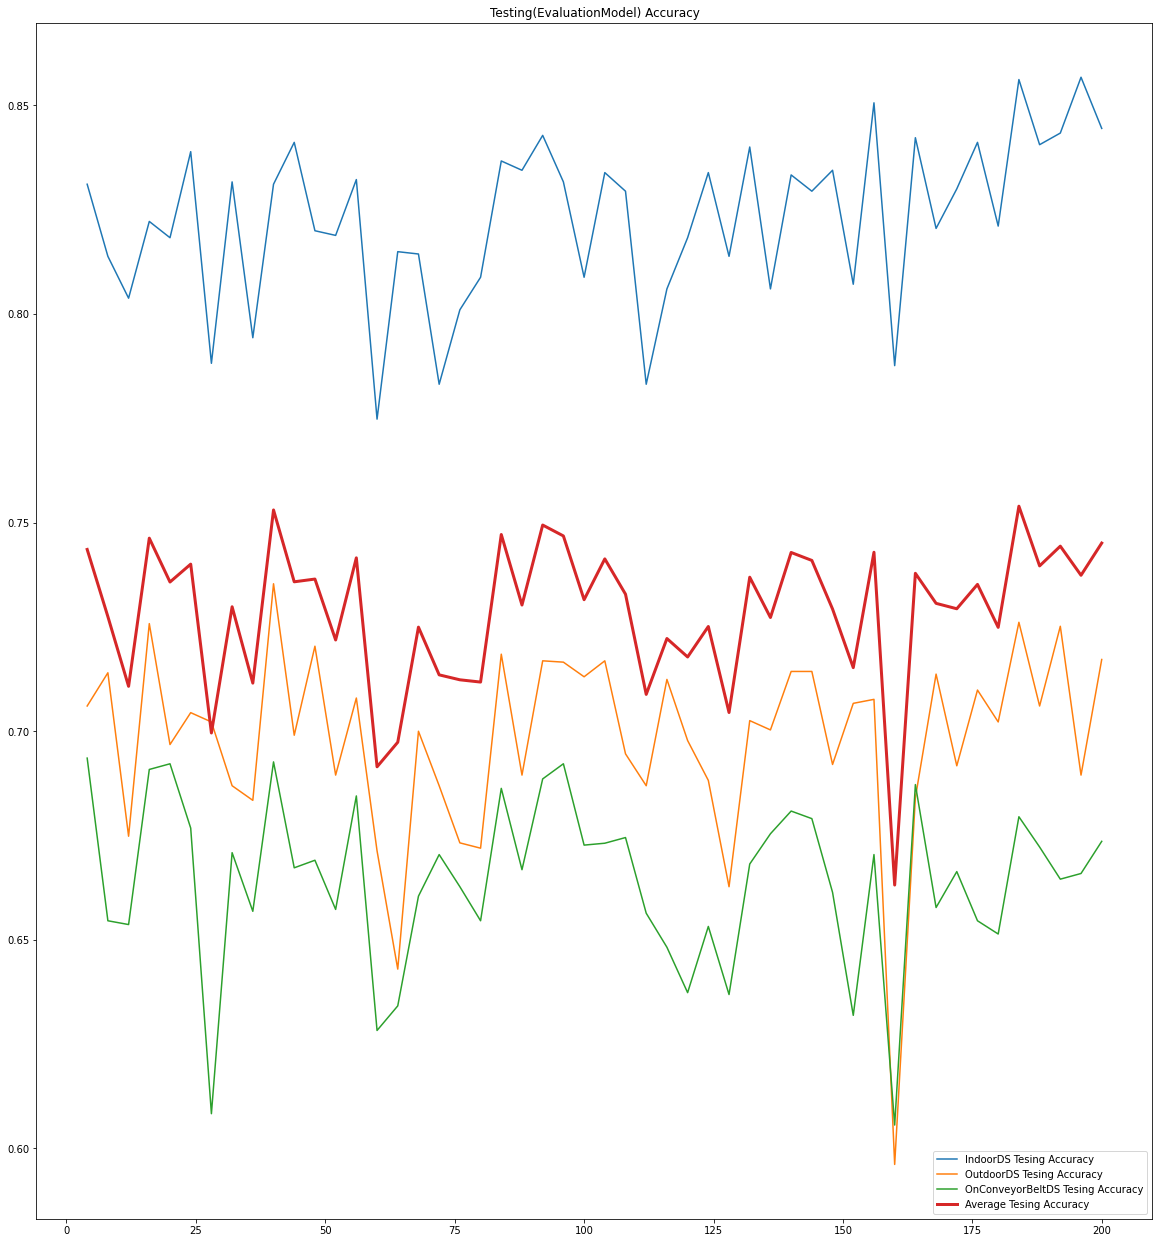

In [31]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.plot(epochs_range, test_avg_acc, label='Average Tesing Accuracy',linewidth=3)
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

In [32]:
#Find Max Index and Value
print(f"max acc -> {max(test_avg_acc)}")
max_index = test_avg_acc.index(max(test_avg_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.7539374430974325
max index -> 45
The [Epoch] of max acc -> 184


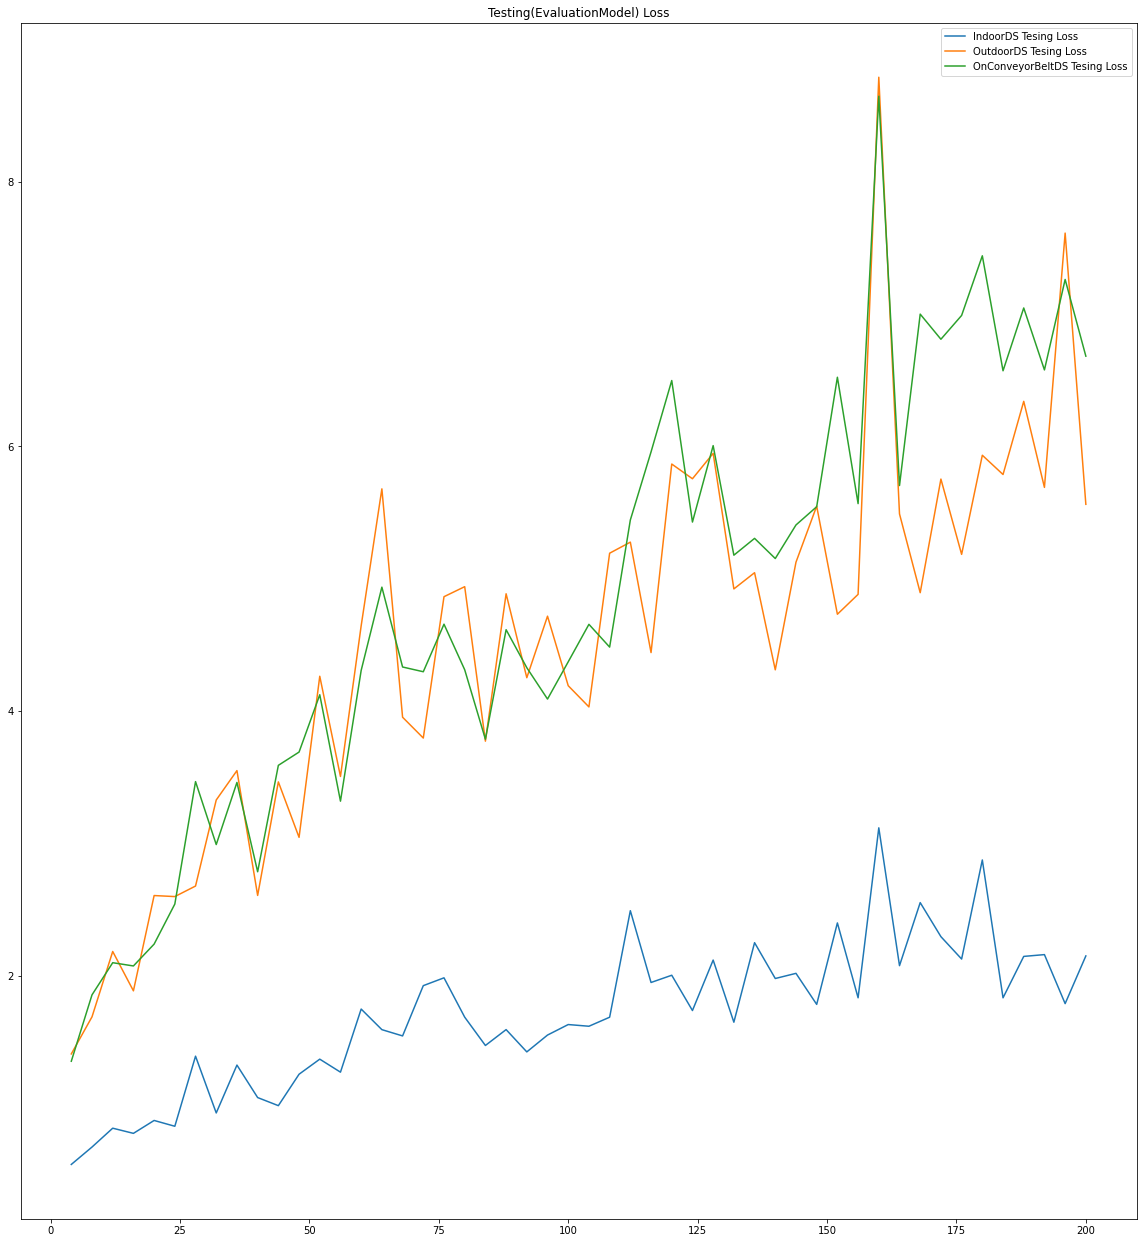

In [33]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [34]:
test_indoor_acc

[0.8311036825180054,
 0.8138238787651062,
 0.8037903904914856,
 0.8221850395202637,
 0.8182831406593323,
 0.8389074802398682,
 0.7881828546524048,
 0.8316611051559448,
 0.7943143844604492,
 0.8311036825180054,
 0.8411371111869812,
 0.8199554085731506,
 0.8188405632972717,
 0.8322185277938843,
 0.7748048901557922,
 0.8149386644363403,
 0.8143812417984009,
 0.7831661105155945,
 0.8010033369064331,
 0.8088071346282959,
 0.8366777896881104,
 0.8344481587409973,
 0.8428093791007996,
 0.8316611051559448,
 0.8088071346282959,
 0.8338907361030579,
 0.829431414604187,
 0.7831661105155945,
 0.8060200810432434,
 0.8182831406593323,
 0.8338907361030579,
 0.8138238787651062,
 0.8400223255157471,
 0.8060200810432434,
 0.8333333134651184,
 0.829431414604187,
 0.8344481587409973,
 0.8071348667144775,
 0.8506131768226624,
 0.7876254320144653,
 0.8422519564628601,
 0.8205128312110901,
 0.8299888372421265,
 0.8411371111869812,
 0.8210702538490295,
 0.8561872839927673,
 0.8405796885490417,
 0.843366801738

In [35]:
test_outdoor_acc

[0.7060509324073792,
 0.7140127420425415,
 0.6748407483100891,
 0.7257961630821228,
 0.6968153119087219,
 0.7044585943222046,
 0.7022293210029602,
 0.6869426965713501,
 0.6834394931793213,
 0.7353503108024597,
 0.6990445852279663,
 0.7203821539878845,
 0.6894904375076294,
 0.7079617977142334,
 0.6713376045227051,
 0.6429936289787292,
 0.699999988079071,
 0.6869426965713501,
 0.6732484102249146,
 0.6719745397567749,
 0.718471348285675,
 0.6894904375076294,
 0.7168790102005005,
 0.7165604829788208,
 0.7130573391914368,
 0.7168790102005005,
 0.6945859789848328,
 0.6869426965713501,
 0.7124204039573669,
 0.6977707147598267,
 0.6882165670394897,
 0.6627388596534729,
 0.7025477886199951,
 0.700318455696106,
 0.7143312096595764,
 0.7143312096595764,
 0.6920382380485535,
 0.7066879272460938,
 0.7076433300971985,
 0.5961783528327942,
 0.6840764284133911,
 0.7136942744255066,
 0.6917197704315186,
 0.7098726034164429,
 0.7022293210029602,
 0.7261146306991577,
 0.7060509324073792,
 0.7251592278480

In [36]:
test_belt_acc

[0.6935629844665527,
 0.654578447341919,
 0.6536718010902405,
 0.6908431649208069,
 0.6922031044960022,
 0.6767905950546265,
 0.608340859413147,
 0.6708975434303284,
 0.656844973564148,
 0.692656397819519,
 0.667271077632904,
 0.6690843105316162,
 0.6572982668876648,
 0.6844968199729919,
 0.6282864809036255,
 0.6341795325279236,
 0.6604714393615723,
 0.6704442501068115,
 0.6627379655838013,
 0.654578447341919,
 0.6863100528717041,
 0.6668177843093872,
 0.6885766386985779,
 0.6922031044960022,
 0.6727107763290405,
 0.6731640696525574,
 0.6745240092277527,
 0.6563916802406311,
 0.648232102394104,
 0.6373526453971863,
 0.6532185077667236,
 0.6368993520736694,
 0.6681777238845825,
 0.6754306554794312,
 0.6808703541755676,
 0.6790571212768555,
 0.6613780856132507,
 0.6319129467010498,
 0.6704442501068115,
 0.6056210398674011,
 0.6872166991233826,
 0.6577515602111816,
 0.6663644313812256,
 0.654578447341919,
 0.6514052748680115,
 0.6795104146003723,
 0.6722574830055237,
 0.6645511984825134,


In [37]:
test_indoor_loss

[0.5737515687942505,
 0.7052339315414429,
 0.8476724028587341,
 0.8086223006248474,
 0.9060948491096497,
 0.8622156977653503,
 1.391822338104248,
 0.9628781676292419,
 1.3245176076889038,
 1.0791124105453491,
 1.017960548400879,
 1.2554165124893188,
 1.3693181276321411,
 1.271055817604065,
 1.7479315996170044,
 1.5923473834991455,
 1.5448949337005615,
 1.9247403144836426,
 1.983938217163086,
 1.686708688735962,
 1.4727303981781006,
 1.5926779508590698,
 1.4241762161254883,
 1.5514081716537476,
 1.6308555603027344,
 1.6180552244186401,
 1.6862401962280273,
 2.4912095069885254,
 1.9486916065216064,
 2.0034451484680176,
 1.7367888689041138,
 2.118117094039917,
 1.6485934257507324,
 2.249539375305176,
 1.9787882566452026,
 2.0177559852600098,
 1.7831823825836182,
 2.39874267578125,
 1.8329795598983765,
 3.117356777191162,
 2.0758824348449707,
 2.5522680282592773,
 2.2950263023376465,
 2.125959873199463,
 2.8746042251586914,
 1.8328367471694946,
 2.145803213119507,
 2.1593174934387207,
 1.7

In [38]:
test_outdoor_loss

[1.408803105354309,
 1.689178705215454,
 2.182957649230957,
 1.8856269121170044,
 2.6056580543518066,
 2.597864866256714,
 2.6775221824645996,
 3.327808380126953,
 3.549736261367798,
 2.606609582901001,
 3.4643545150756836,
 3.0454633235931396,
 4.2627692222595215,
 3.5054030418395996,
 4.6444010734558105,
 5.678814888000488,
 3.9531924724578857,
 3.7959482669830322,
 4.863935947418213,
 4.939713001251221,
 3.7722761631011963,
 4.885931491851807,
 4.25175142288208,
 4.71674108505249,
 4.191298484802246,
 4.031124114990234,
 5.192567348480225,
 5.276236534118652,
 4.4417219161987305,
 5.866416931152344,
 5.755277156829834,
 5.947147369384766,
 4.922685146331787,
 5.045216083526611,
 4.311441421508789,
 5.124726295471191,
 5.548304557800293,
 4.731342792510986,
 4.881665229797363,
 8.789280891418457,
 5.489404678344727,
 4.894256114959717,
 5.752776145935059,
 5.183913230895996,
 5.932883262634277,
 5.787290573120117,
 6.340182781219482,
 5.689974308013916,
 7.611557483673096,
 5.5620508

In [39]:
test_belt_loss

[1.3536452054977417,
 1.8552452325820923,
 2.0982208251953125,
 2.073568105697632,
 2.2387948036193848,
 2.5414838790893555,
 3.4666850566864014,
 2.9910051822662354,
 3.460393190383911,
 2.7854838371276855,
 3.5895795822143555,
 3.6899023056030273,
 4.122973442077637,
 3.318887233734131,
 4.307002067565918,
 4.936056613922119,
 4.332698822021484,
 4.296874046325684,
 4.656106472015381,
 4.3119072914123535,
 3.787088632583618,
 4.614523887634277,
 4.327253818511963,
 4.090409755706787,
 4.372000217437744,
 4.655134201049805,
 4.483135223388672,
 5.44358491897583,
 5.9580841064453125,
 6.49744176864624,
 5.428103923797607,
 6.005539417266846,
 5.177606582641602,
 5.304701328277588,
 5.152429103851318,
 5.405981540679932,
 5.543718338012695,
 6.522195339202881,
 5.567275047302246,
 8.646186828613281,
 5.703827857971191,
 6.999223232269287,
 6.809445381164551,
 6.989314556121826,
 7.4400224685668945,
 6.571136951446533,
 7.045741081237793,
 6.577687740325928,
 7.261115550994873,
 6.681457

## Load Last Epoch and test in each class

In [29]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
#from numba import cuda
#cuda.select_device(0)
#cuda.close()

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer-DeepDense-Oversampling-NoAug-epoch0184-val_acc1.00.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
del x_test_indoor,x_test_outdoor,x_test_belt
del y_test_indoor,y_test_outdoor,y_test_belt
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [4]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=5315
FP=1825
acc=0.7443977591036415
all check = 7140


In [5]:
print(TP_eachclass)

[56, 130, 80, 111, 109, 134, 40, 99, 127, 121, 89, 74, 39, 114, 62, 126, 280, 62, 120, 323, 62, 79, 222, 128, 112, 256, 663, 111, 103, 72, 101, 108, 86, 104, 97, 88, 244, 41, 90, 175, 77]


In [6]:
print(FP_eachclass)

[60, 17, 54, 6, 2, 26, 86, 67, 40, 22, 28, 39, 84, 48, 51, 50, 56, 50, 142, 62, 93, 34, 58, 5, 12, 172, 51, 18, 14, 59, 17, 19, 24, 9, 14, 44, 19, 68, 30, 38, 37]


In [7]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 48.275862068965516%
2WayConnectorforFoley acc = 88.43537414965986%
2WayFoleyCatheter acc = 59.70149253731343%
3WayConnectorforFoley acc = 94.87179487179486%
3Waystopcock acc = 98.1981981981982%
AlcoholBottle acc = 83.75%
AlcoholPad acc = 31.746031746031743%
BootCover acc = 59.63855421686747%
CottonBall acc = 76.04790419161677%
CottonSwap acc = 84.61538461538461%
Dilator acc = 76.06837606837607%
DisposableInfusionSet acc = 65.48672566371681%
ExtensionTube acc = 31.70731707317073%
FaceShield acc = 70.37037037037037%
FrontLoadSyringe acc = 54.86725663716814%
GauzePad acc = 71.5909090909091%
Glove acc = 83.33333333333334%
GuideWire acc = 55.35714285714286%
LiquidBottle acc = 45.80152671755725%
Mask acc = 83.8961038961039%
NGTube acc = 40.0%
NasalCannula acc = 69.91150442477876%
Needle acc = 79.28571428571428%
OxygenMask acc = 96.2406015037594%
PPESuit acc = 90.32258064516128%
PharmaceuticalProduct acc = 59.813084112149525%
Pill acc = 92.85714285714286%
PillBottl

In [8]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 56,   2,   0, ...,   1,   1,   0],
       [  0, 130,   0, ...,   0,   0,   0],
       [  0,   0,  80, ...,   2,   0,  17],
       ...,
       [  0,   0,   0, ...,  90,   1,   0],
       [  0,   0,   0, ...,   1, 175,   0],
       [  0,   0,   0, ...,   6,   0,  77]], dtype=int64)

In [9]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[48.27586207,  1.72413793,  0.        , ...,  0.86206897,
         0.86206897,  0.        ],
       [ 0.        , 88.43537415,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 59.70149254, ...,  1.49253731,
         0.        , 12.68656716],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 75.        ,
         0.83333333,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.46948357,
        82.15962441,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  5.26315789,
         0.        , 67.54385965]])

<AxesSubplot:>

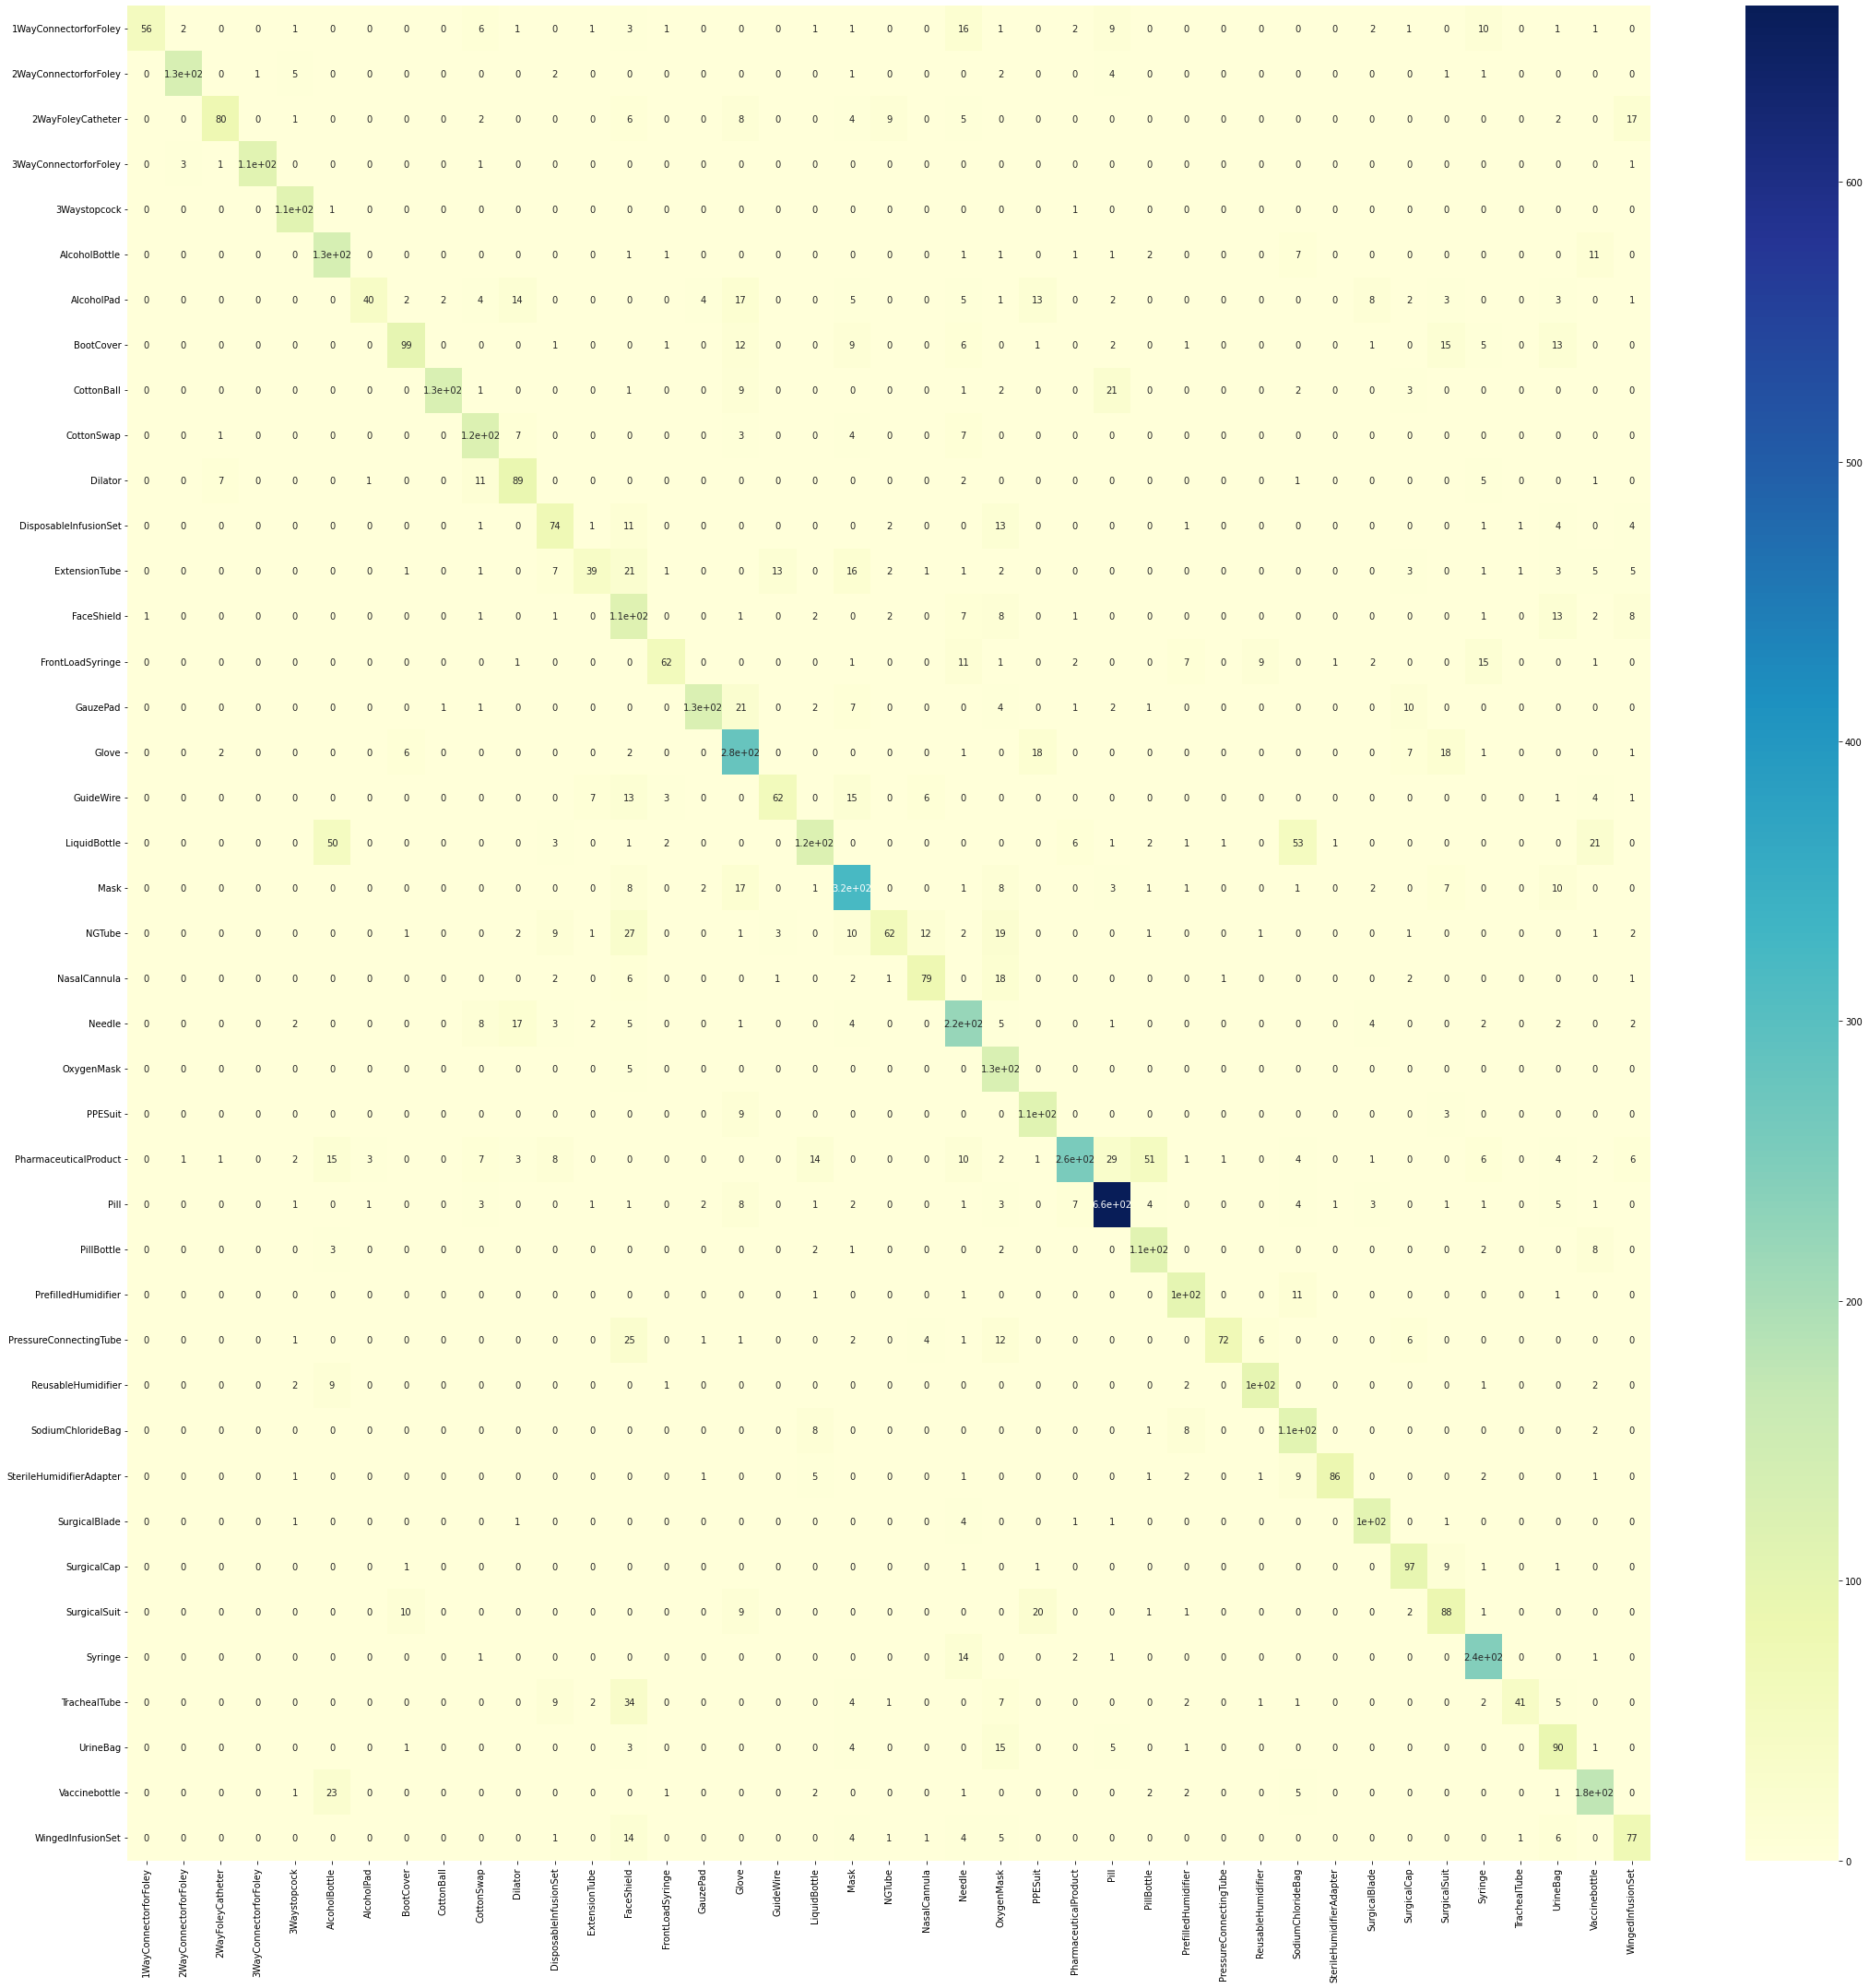

In [10]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

<AxesSubplot:>

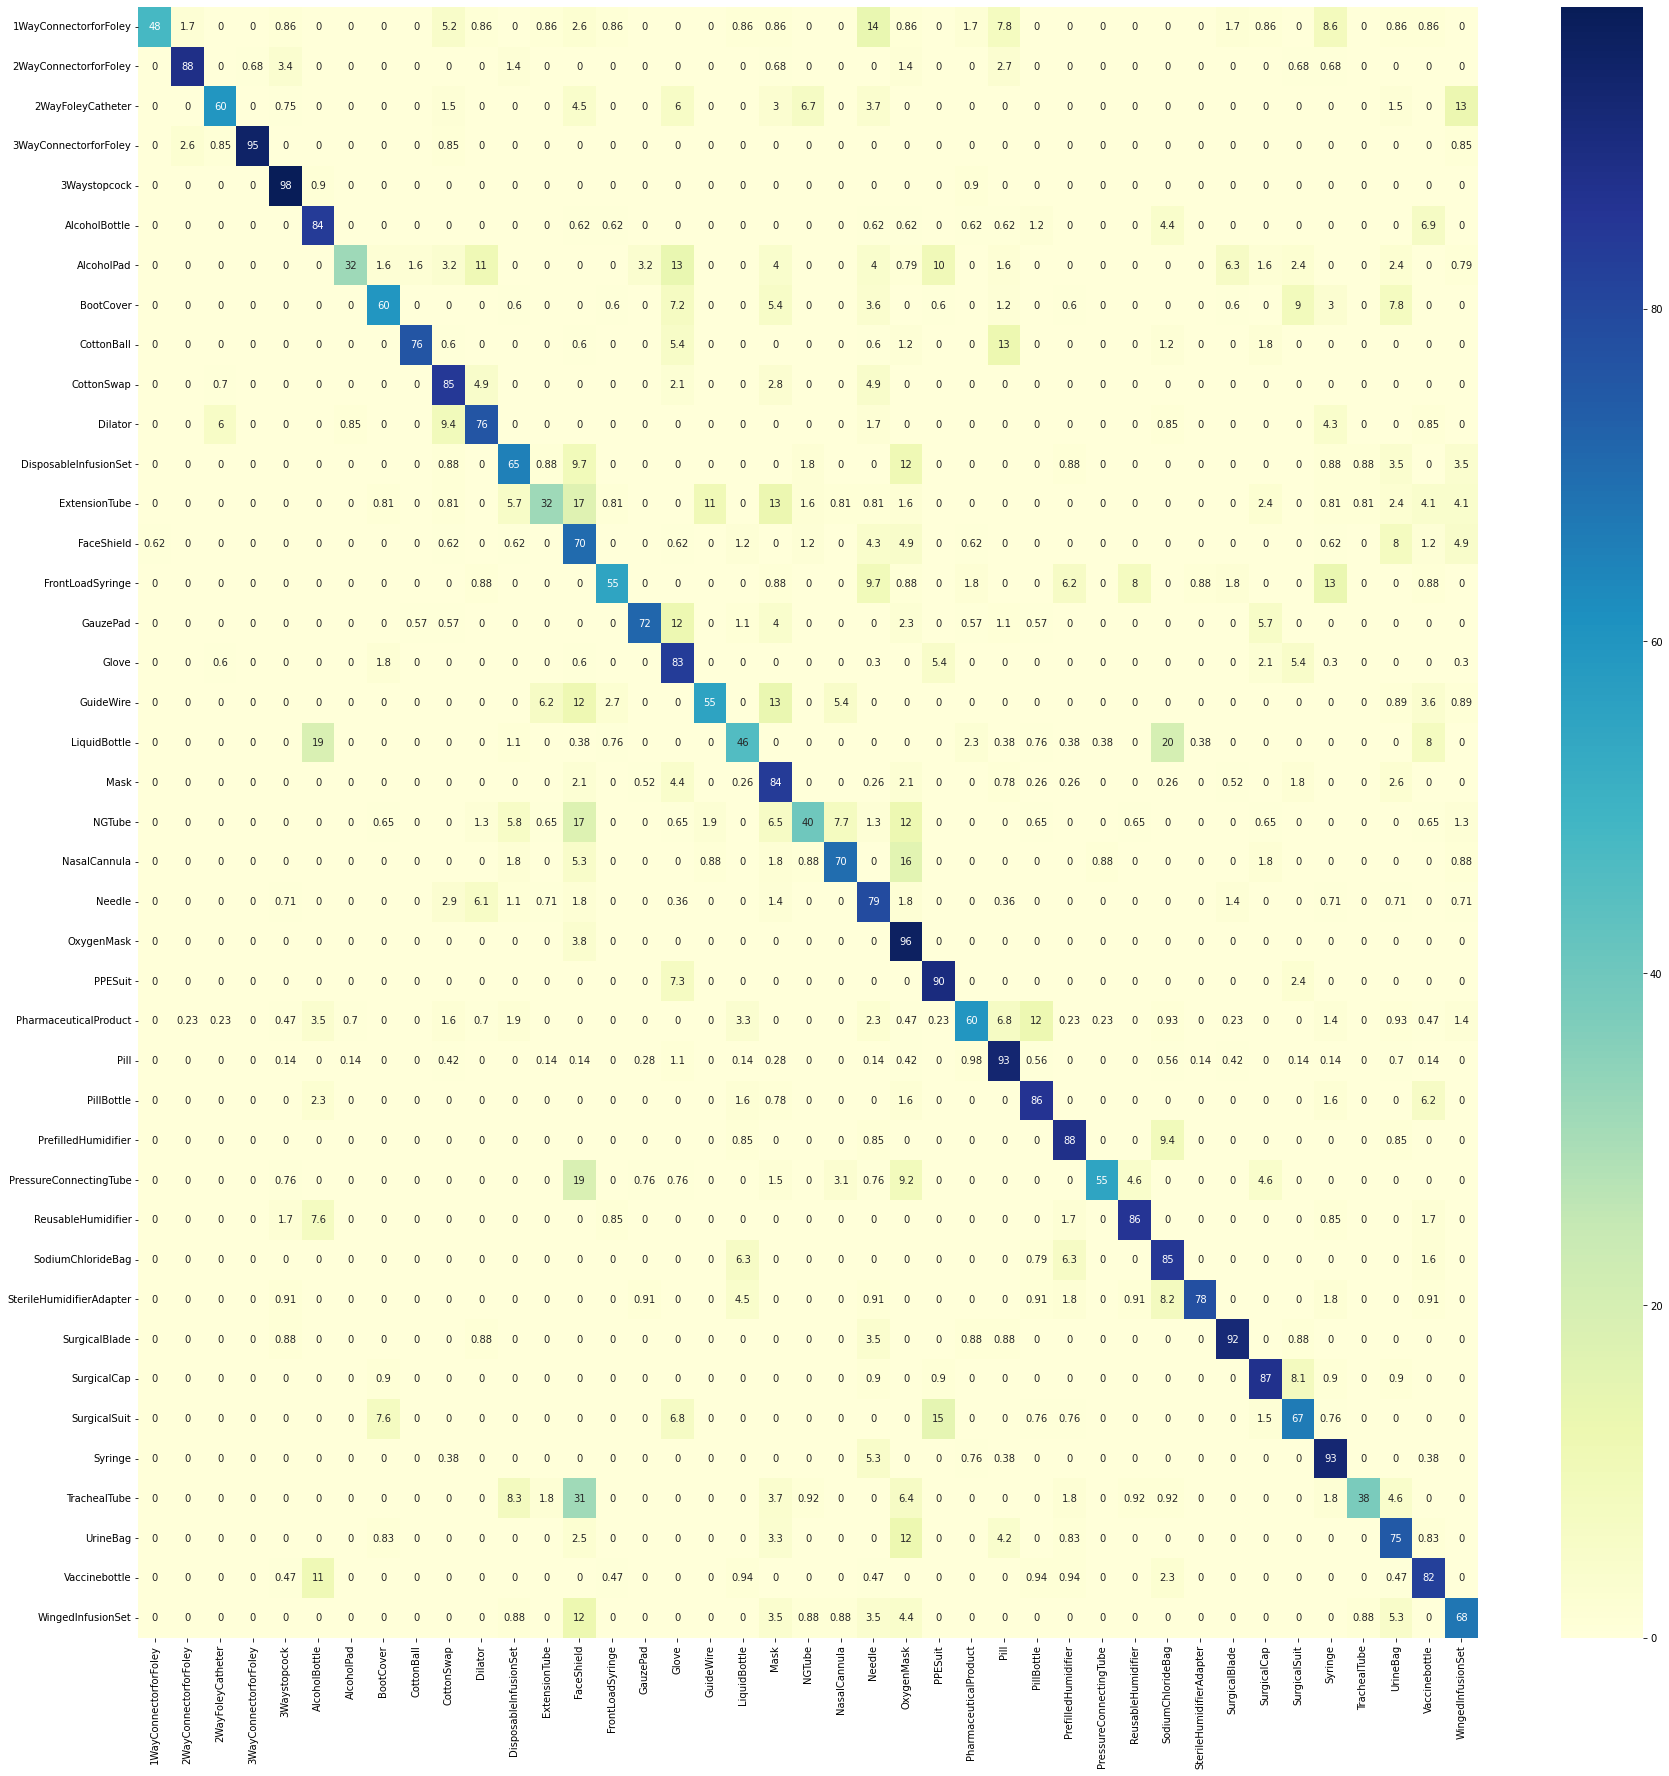

In [11]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")